In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import word_tokenize

In [5]:
tweets = pd.read_csv("./Tweets.csv")

In [12]:
tweets.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
tweets.shape

(14640, 15)

In [20]:
#this
review_dataset["tweet_coord"].dropna()
# or this
review_dataset["tweet_coord"][~review_dataset["tweet_coord"].isnull()]


21        [40.74804263, -73.99295302]
28          [42.361016, -71.02000488]
29        [33.94540417, -118.4062472]
32       [33.94209449, -118.40410103]
34          [33.2145038, -96.9321504]
                     ...             
14577    [33.93939612, -118.38973148]
14596    [35.22534456, -106.57241352]
14612     [40.46692522, -82.64567078]
14624      [32.9070889, -97.03785947]
14625     [40.64946781, -73.76624703]
Name: tweet_coord, Length: 1019, dtype: object

In [13]:
tweets.text.tail()

14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, dtype: object

(-0.5, 399.5, 199.5, -0.5)

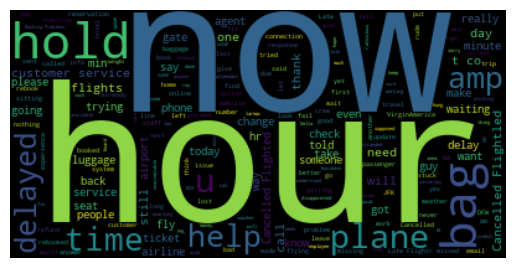

In [26]:
from wordcloud import WordCloud, STOPWORDS
# Building a word cloud for negative tweet text
negative_tweets = tweets["text"][tweets["airline_sentiment"] =="negative"]
joined_negative_tweets = "".join(negative_tweets)

my_stop_words = set(STOPWORDS)
# reg = r"@"|
my_stop_words = my_stop_words.union(["@VirginAmerica", "united","flight","AmericanAir","USAirways","SouthwestAir","JetBlue"])
word_cloud = WordCloud(stopwords=my_stop_words).generate(joined_negative_tweets)

#show word cloud
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")




(-0.5, 399.5, 199.5, -0.5)

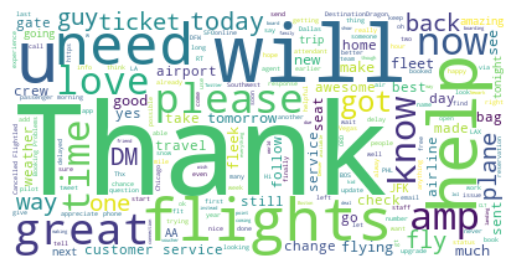

In [39]:
from wordcloud import WordCloud, STOPWORDS
# Building a word cloud for negative tweet text
# positive_neutral_tweets = tweets["text"][~tweets["airline_sentiment"] =="negative"]
positive_neutral_tweets = tweets["text"][tweets["airline_sentiment"] !="negative"]
joined_positive_neutral_tweets = "".join(positive_neutral_tweets)

my_stop_words = set(STOPWORDS)
# reg = r"@"|
my_stop_words = my_stop_words.union(["@VirginAmerica", "united","flight","AmericanAir","USAirways","SouthwestAir", "JetBlue","VirginAmerica","co", "t"])
word_cloud = WordCloud(background_color="white", stopwords=my_stop_words).generate(joined_positive_neutral_tweets)

#show word cloud
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")


